# Построение моделей и интерпретация (Telco Churn)
Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
import shap

df = pd.read_csv('data/telco_processed.csv')

### Целевая переменная

In [4]:
X = df.drop(columns=['Churn'])
y = df['Churn']

### Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Масштабирование + Logistic Regression

In [6]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=5000))
])

### Кросс-валидация (ROC AUC)

In [7]:
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
print("CV ROC AUC (LogReg):", scores.mean())

CV ROC AUC (LogReg): 0.8394540751971784


~83.85%

### Обучение финальной модели

In [8]:
pipe.fit(X_train, y_train)
y_pred_proba_lr = pipe.predict_proba(X_test)[:, 1]
y_pred_lr = pipe.predict(X_test)

print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1035
           1       0.70      0.32      0.44       374

    accuracy                           0.78      1409
   macro avg       0.75      0.64      0.65      1409
weighted avg       0.77      0.78      0.75      1409



### Посмотроим Confusion Matrix

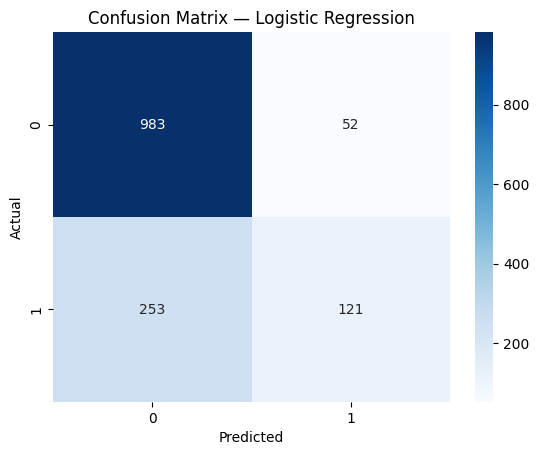

In [9]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### CatBoost (без OneHot)

In [10]:
cat_features = [i for i in X.columns if 'object' in str(X[i].dtype)]
model_cat = CatBoostClassifier(verbose=0, random_state=42)
model_cat.fit(X_train, y_train, cat_features=cat_features)

### Предсказания CatBoost

In [11]:
y_pred_proba_cat = model_cat.predict_proba(X_test)[:, 1]
y_pred_cat = model_cat.predict(X_test)

print("\nCatBoost Report:")
print(classification_report(y_test, y_pred_cat))


CatBoost Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.68      0.49      0.57       374

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



### Сравним метрики Регрессии и CatBoost

In [12]:
print("\nROC AUC:")
print("Logistic Regression:", roc_auc_score(y_test, y_pred_proba_lr))
print("CatBoost:", roc_auc_score(y_test, y_pred_proba_cat))


ROC AUC:
Logistic Regression: 0.8335477537523575
CatBoost: 0.8479423389909322


### SHAP анализ

In [13]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(X_test)

### Построим Summary plot

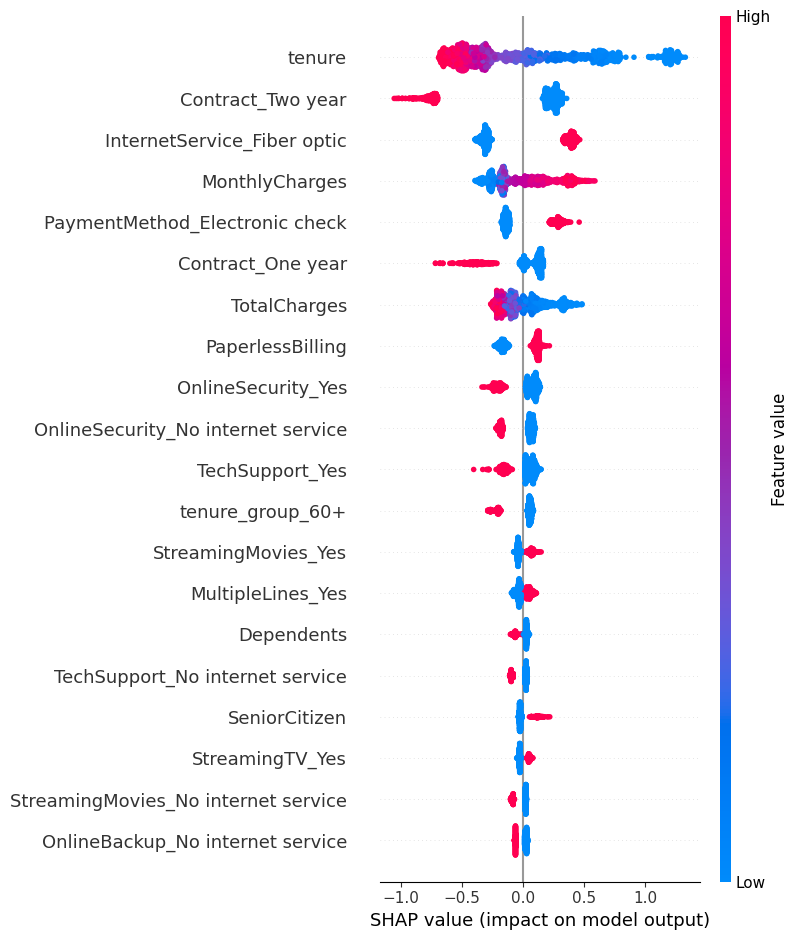

In [14]:
shap.summary_plot(shap_values, X_test)

### Оценим важность признаков для моделирования

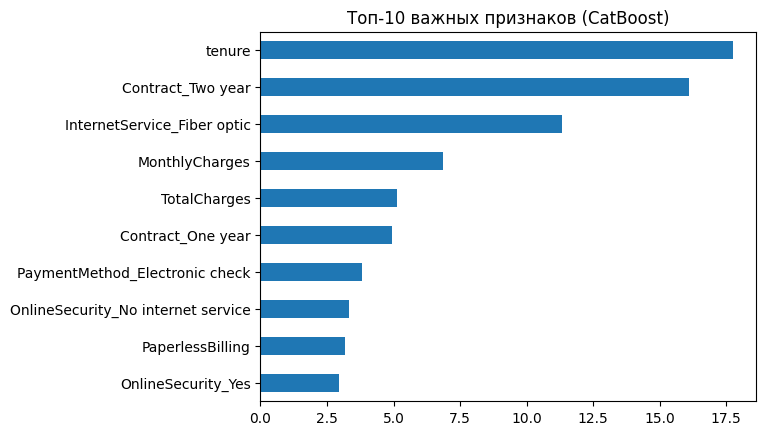

In [15]:
feature_importance = pd.Series(model_cat.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Топ-10 важных признаков (CatBoost)")
plt.gca().invert_yaxis()
plt.show()